In [2]:
import numpy as np
import pandas as pd
import scipy.special as sc
from scipy.stats import beta
import matplotlib.pyplot as plt


from functools import partial

# Generate Random Sampels

In [3]:
np.random.seed(1)
theta1 = 0.5
theta2 = 0.55
n = 1000
x = np.zeros(n+1)
for i in range(1, n+1):
    x[i] = np.random.binomial(1, theta1**(1-x[i-1])*theta2**(x[i-1]))

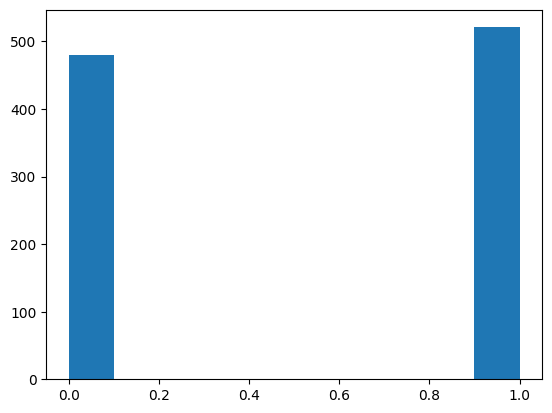

In [4]:
plt.hist(x);

# Task 1. Inference on theta0 and theta1

## Compute Posterior Mean by Formula

In [5]:
S00 = np.sum((x[:-1] == 0) & (x[1:] == 0))
S01 = np.sum((x[:-1] == 0) & (x[1:] == 1))
S10 = np.sum((x[:-1] == 1) & (x[1:] == 0))
S11 = np.sum((x[:-1] == 1) & (x[1:] == 1))


In [6]:
# np.rand?om.seed(2)
J = 500
theta = np.zeros((J, 2))

# beta 0
theta[:,0] = np.random.beta(1+S01, 1+S00, J)
# beta 1
theta[:,1] = np.random.beta(1+S11, 1+S10, J)

# Get Posterior Mean
print(f"mean: {np.mean(theta, axis =0 )}")
print(f"std: {np.std(theta, axis =0 )}")

mean: [0.50441339 0.53665388]
std: [0.02317264 0.02255447]


In [7]:
def posterior_pi(theta0, theta1, S00, S01, S10, S11):
    return np.exp(beta.logpdf(theta0, S00, S01) + beta.logpdf(theta1, S11, S10))

posterior_t1 = partial(posterior_pi, S00 = S00, S01 = S01, S10 = S10, S11 = S11)

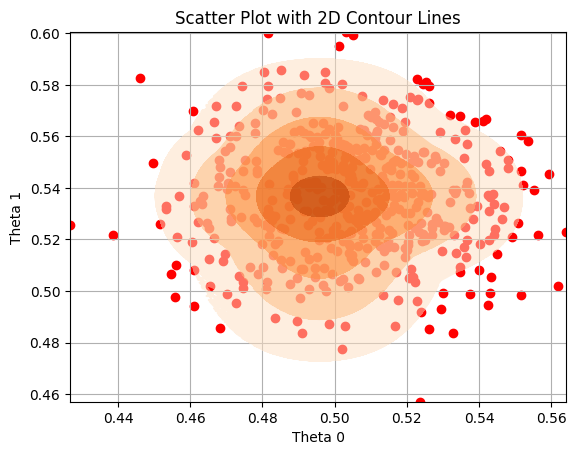

In [8]:
x = theta[:, 0]
y = theta[:, 1]

X, Y = np.meshgrid(x, y)
Z = posterior_t1(X, Y)


plt.contour(X, Y, Z, levels=5, alpha=0.5, cmap='Oranges')  # Updated cmap to 'Oranges'
plt.scatter(x, y, color = 'red')
plt.grid()

# Add labels and title
plt.xlabel('Theta 0')
plt.ylabel('Theta 1')
plt.title('Scatter Plot with 2D Contour Lines')

# Show the plot
plt.show()


# Task 2 
(We add a constraint that theta0 < theta1 )

# Compute Postieror Mean by Simulation

## Naive Proposal

In [54]:
def get_alpha_beta(theta, sigma = 0.05):

    # sigma_sq = sigma **2
    # sigma0_sq = min(sigma_sq, theta*(1-theta)*0.99)
    # alpha = theta ** 2 * (1-theta) / sigma0_sq - theta
    # beta = alpha * (1 - theta) / theta
    alpha = 0.5
    beta = 0.5
    return alpha, beta

def log_pdf_u(theta):
    return np.log(posterior_t1(theta[0], theta[1]) + 1e-7) - 9**99 * (theta[0]> theta[1])

def log_pdf_p(theta, theta_conditional):
    alpha0, beta0 = get_alpha_beta(theta_conditional[0])
    alpha1, beta1 = get_alpha_beta(theta_conditional[1])
    return beta.logpdf(theta[0], alpha0, beta0) + beta.logpdf(theta[1], alpha1, beta1)


In [55]:
J = 2**15
JBurn = int(J*.1)


# Running the MH Algorithm
np.random.seed(3)
accepted = 0
theta = np.zeros((J+1, 2))
theta[0, :] = np.random.uniform(size = 2)
print(theta[0, :])
for j in range(1, J+1):
    np.random.seed(j)
    para_j0 = get_alpha_beta(theta[j-1][0], 0.05)
    para_j1 = get_alpha_beta(theta[j-1][1], 0.05)
    
    theta_tilde_j0= np.random.beta(para_j0[0], para_j0[1]) # this is our proposal for theta 0
    theta_tilde_j1= np.random.beta(para_j1[0], para_j1[1]) # this is our proposal for theta 1
    theta_tilde = np.array([theta_tilde_j0, theta_tilde_j1])

    a = np.minimum(0, log_pdf_u(theta_tilde ) + log_pdf_p(theta[j-1, :], theta_tilde) \
                - log_pdf_u(theta[j-1, :]) - log_pdf_p(theta_tilde, theta[j-1, :]))
    u = np.random.uniform(size = 1)

    if u < np.exp(a):
        accepted += 1
    theta[j, :] = theta_tilde * (u < np.exp(a)) + theta[j-1, :] * (u >= np.exp(a))

print(f"Accepted: {accepted/J}")

[0.5507979  0.70814782]


In [ ]:
thetause = theta[JBurn:, :]
print(f"mean: {np.mean(thetause, axis =0 )}")
print(f"std: {np.std(thetause, axis =0 )}")

mean: [0.49273545 0.53935367]
std: [0.02095015 0.02007369]


## Better Proposal

In [48]:
def get_alpha_beta(theta, sigma = 0.05):

    sigma_sq = sigma **2
    sigma0_sq = min(sigma_sq, theta*(1-theta)*0.99)
    alpha = theta ** 2 * (1-theta) / sigma0_sq - theta
    beta = alpha * (1 - theta) / theta
    # alpha = 0.5
    # beta = 0.5
    return alpha, beta

def log_pdf_u(theta):
    return np.log(posterior_t1(theta[0], theta[1]) + 1e-7) - 9**99 * (theta[0]> theta[1])

def log_pdf_p(theta, theta_conditional):
    alpha0, beta0 = get_alpha_beta(theta_conditional[0])
    alpha1, beta1 = get_alpha_beta(theta_conditional[1])
    return beta.logpdf(theta[0], alpha0, beta0) + beta.logpdf(theta[1], alpha1, beta1)


In [50]:
J = 2**15
JBurn = int(J*.1)


# Running the MH Algorithm
np.random.seed(3)
accepted = 0
theta = np.zeros((J+1, 2))
theta[0, :] = np.random.uniform(size = 2)
print(theta[0, :])
for j in range(1, J+1):
    np.random.seed(j)
    para_j0 = get_alpha_beta(theta[j-1][0], 0.05)
    para_j1 = get_alpha_beta(theta[j-1][1], 0.05)
    
    theta_tilde_j0= np.random.beta(para_j0[0], para_j0[1]) # this is our proposal for theta 0
    theta_tilde_j1= np.random.beta(para_j1[0], para_j1[1]) # this is our proposal for theta 1
    theta_tilde = np.array([theta_tilde_j0, theta_tilde_j1])

    a = np.minimum(0, log_pdf_u(theta_tilde ) + log_pdf_p(theta[j-1, :], theta_tilde) \
                - log_pdf_u(theta[j-1, :]) - log_pdf_p(theta_tilde, theta[j-1, :]))
    u = np.random.uniform(size = 1)

    if u < np.exp(a):
        accepted += 1
    theta[j, :] = theta_tilde * (u < np.exp(a)) + theta[j-1, :] * (u >= np.exp(a))

print(f"Accepted: {accepted/J}")

[0.5507979  0.70814782]
Accepted: 0.2220458984375


In [51]:
thetause = theta[JBurn:, :]
print(f"mean: {np.mean(thetause, axis =0 )}")
print(f"std: {np.std(thetause, axis =0 )}")

mean: [0.49273545 0.53935367]
std: [0.02095015 0.02007369]
